# Part 4 · Compound clustering

The similarity principle states that similar molecules bind the same targets and have similar effects. Therefore, rational drug design often starts with a scaffold, from there substituents can be added. In this part compounds will be clustered based on there similarity, to use the cluster in the next part to determine a scaffold, which in turn will be used for generating new compounds. 

#### Load data and calculate fingerprints
Prepare data and calculated the fingerprints.

Import required libraries

In [1]:
import time
import random
from pathlib import Path

import pandas as pd
import numpy
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator


# import sys
# sys.path.append("../../../")
# import teachopencadd
# from teachopencadd.utils import seed_everything
#
# SEED = 24
# seed_everything(SEED) # fix seed to get deterministic outputs

In [2]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [3]:
# Load and have a look into data
# Filtered data taken from part 3
compound_df = pd.read_csv(
    DATA / "BACE_compounds_part3.csv",
    index_col=0,
)

print("Dataframe shape:", compound_df.shape)
compound_df.head()

Dataframe shape: (4823, 6)


,molecule_chembl_id,IC50,units,smiles,pIC50,ro5_fulfilled
0,CHEMBL3969403,0.0002,nM,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3ccc(C#N)cn3)c...,12.698970,True
1,CHEMBL3937515,0.0009,nM,COc1cnc(C(=O)Nc2ccc(F)c([C@]3(C)CS(=O)(=O)C(C)...,12.045757,True
2,CHEMBL3949213,0.0010,nM,C[C@@]1(c2cc(NC(=O)c3ccc(C#N)cn3)ccc2F)CS(=O)(...,12.000000,True
3,CHEMBL3955051,0.0018,nM,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3cnc(C(F)F)cn3...,11.744727,True
4,CHEMBL3936264,0.0057,nM,C[C@@]1(c2cc(NC(=O)c3ccc(OC(F)F)cn3)ccc2F)CS(=...,11.244125,True


In [4]:
# Create molecules from SMILES and store in array
compounds = []
# .itertuples() returns a (index, column1, column2, ...) tuple per row
# we don't need index so we use _ instead
# note how we are slicing the dataframe to only the two columns we need now
for _, chembl_id, smiles in compound_df[["molecule_chembl_id", "smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), chembl_id))
compounds[:5]

[(<rdkit.Chem.rdchem.Mol at 0x7fa017078be0>, 'CHEMBL3969403'),
 (<rdkit.Chem.rdchem.Mol at 0x7fa0170b83a0>, 'CHEMBL3937515'),
 (<rdkit.Chem.rdchem.Mol at 0x7fa0170ba020>, 'CHEMBL3949213'),
 (<rdkit.Chem.rdchem.Mol at 0x7fa0170b99c0>, 'CHEMBL3955051'),
 (<rdkit.Chem.rdchem.Mol at 0x7fa0170ba140>, 'CHEMBL3936264')]

The similarity will be based on the fingerprints of the molecules. Fingerprints describe the molecule in a bit string by indicating the presence of a substructure. 

In [5]:
# Create fingerprints for all molecules
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_gen.GetFingerprint(mol) for mol, idx in compounds]

# How many compounds/fingerprints do we have?
print("Number of compounds converted:", len(fingerprints))
print("Fingerprint length per compound:", len(fingerprints[0]))
# NBVAL_CHECK_OUTPUT

Number of compounds converted: 4823
Fingerprint length per compound: 2048


#### Tanimoto similarity and distance matrix
Identify potential cluster centroids. Therefore, first define functions to calculate the Tanimoto similarity and distance matrix. The tanimoto coefficient is used as similarity coefficient to compare the fingerprints of the molecules and quantify the similarity. A point to be critical at, is that the fingerprints are bitstrings, and therefore if a substructure is already on it can not be 'more on'. So a tanimoto of 1 can be altrough the structures are not the same in the case that one of them has a substructure twice. From the similarity coefficients will a similarity matrix be made, to quantify similarity between the set of molecules in the dataframe. 

Define a tanimoto distance function

In [6]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    # Notice how we are deliberately skipping the first and last items in the list
    # because we don't need to compare them against themselves
    for i in range(1, len(fp_list)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

#### Clustering molecules: Centroids and exclusion spheres
Cluster the molecules.

Define a clustering function.

[Hoe clusterd deze functie?]

In [7]:
def cluster_fingerprints(fingerprints, cutoff=0.2):
    """Cluster fingerprints
    Parameters:
        fingerprints
        cutoff: threshold for the clustering
    """
    # Calculate Tanimoto distance matrix
    distance_matrix = tanimoto_distance_matrix(fingerprints)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

Cluster the molecules based on their fingerprint similarity.

In [8]:
# Run the clustering procedure for the dataset
clusters = cluster_fingerprints(fingerprints, cutoff=0.3)

# Give a short report about the numbers of clusters and their sizes
num_clust_g1 = sum(1 for c in clusters if len(c) == 1)
num_clust_g5 = sum(1 for c in clusters if len(c) > 5)
num_clust_g25 = sum(1 for c in clusters if len(c) > 25)
num_clust_g100 = sum(1 for c in clusters if len(c) > 100)

# Show how much cluster there are with a certain amount of compounds in it
print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >100 compounds: ", num_clust_g100)
# NBVAL_CHECK_OUTPUT

total # clusters:  511
# clusters with only 1 compound:  203
# clusters with >5 compounds:  140
# clusters with >25 compounds:  32
# clusters with >100 compounds:  7


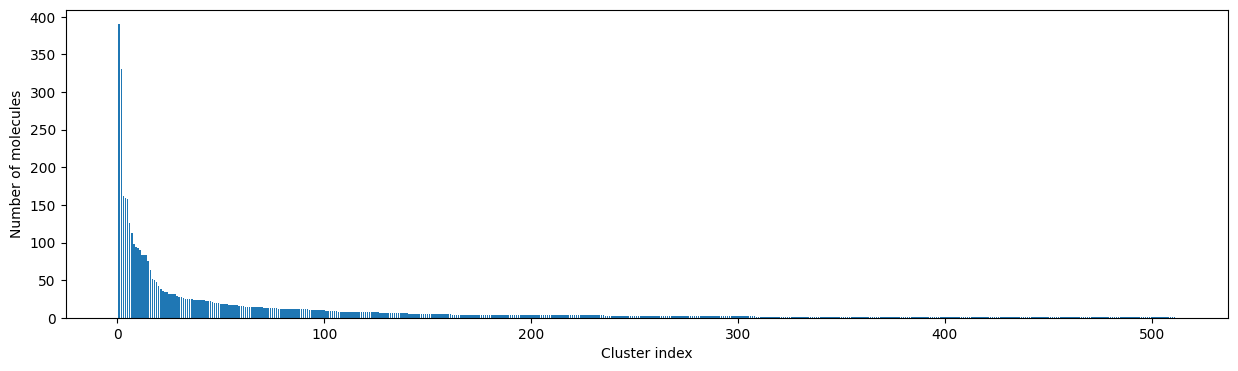

In [9]:
# Plot the size of the clusters
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Number of molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5);

#### Choose a reasonable cutoff
Since the clustering result depends on the chosen threshold,there will be a closer look on the choice of the cutoff.

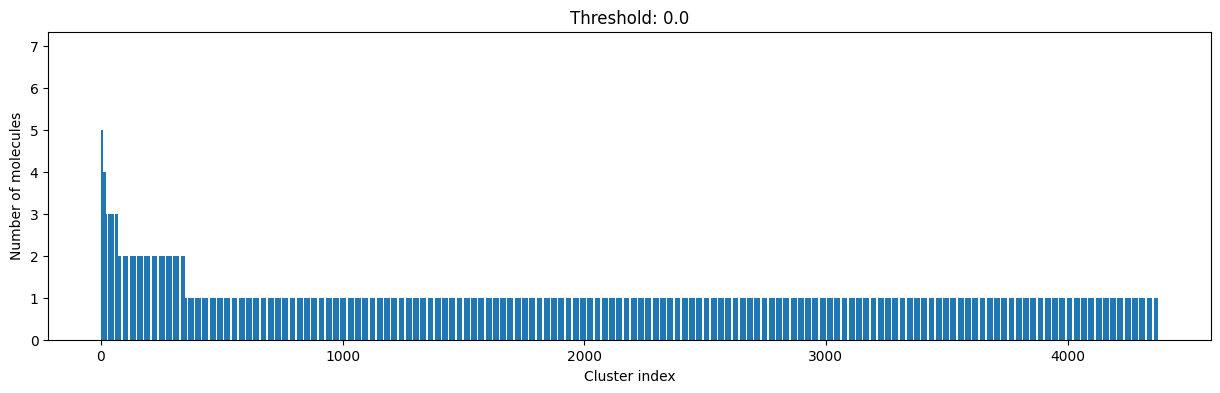

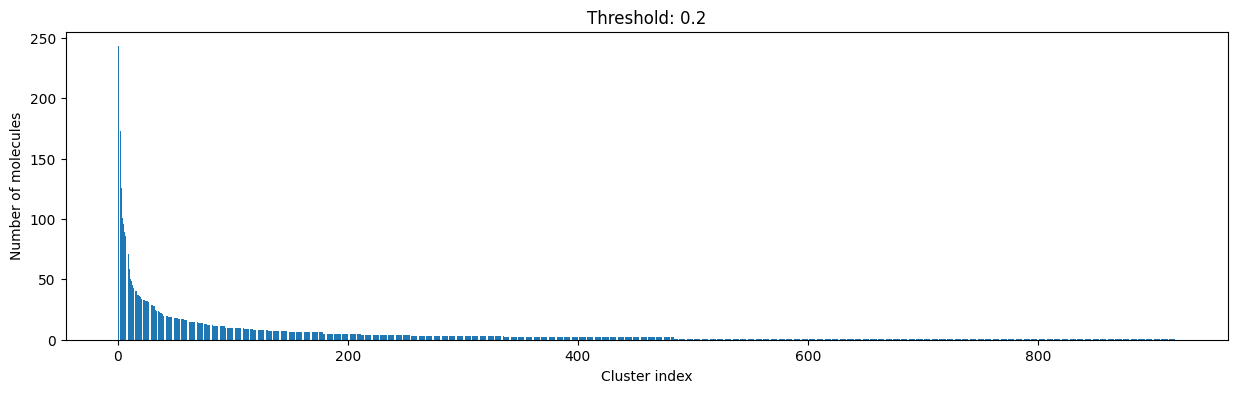

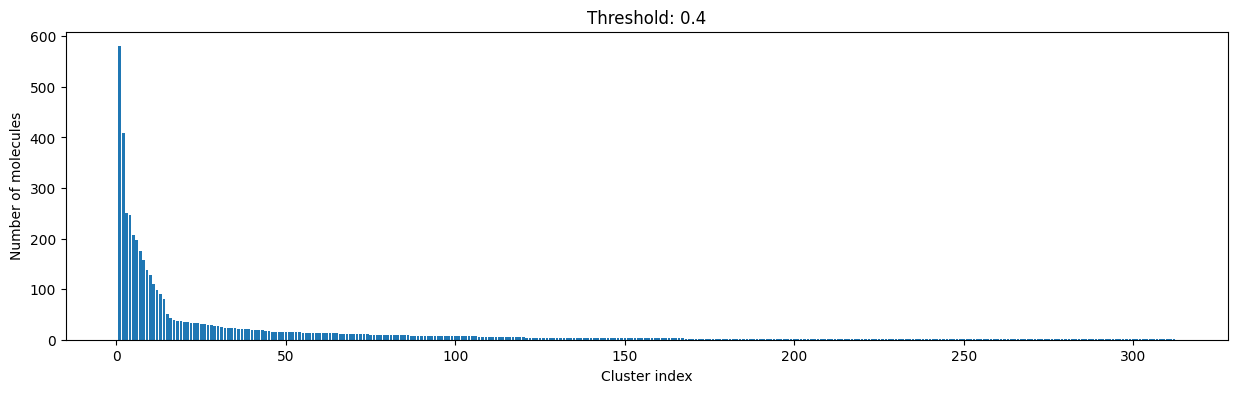

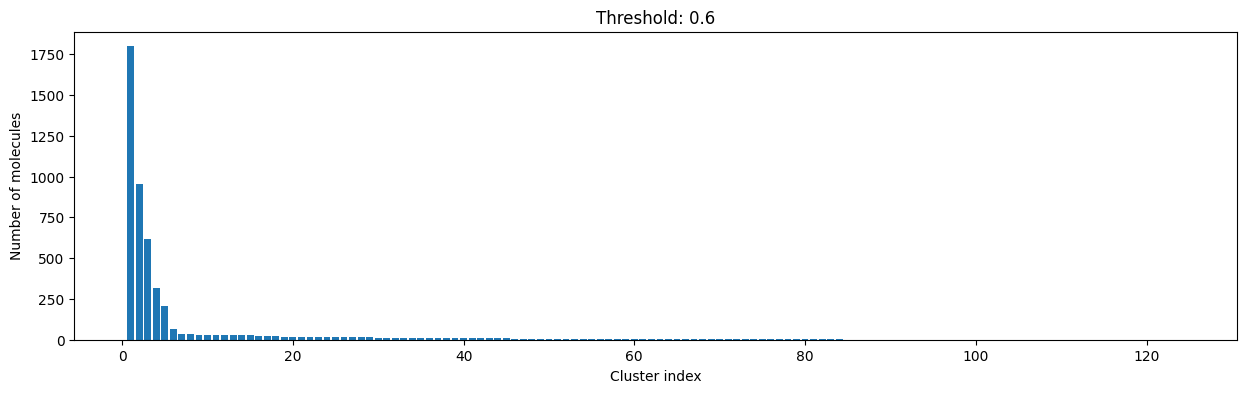

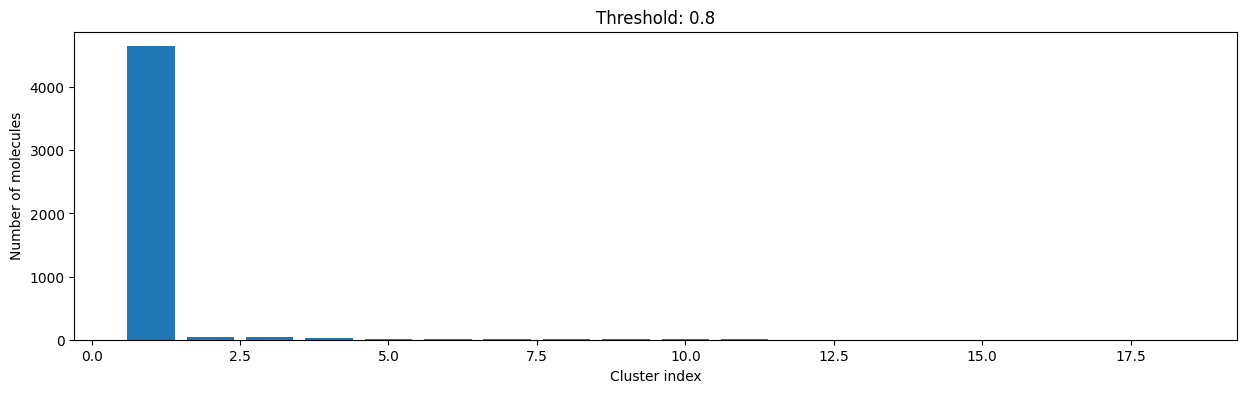

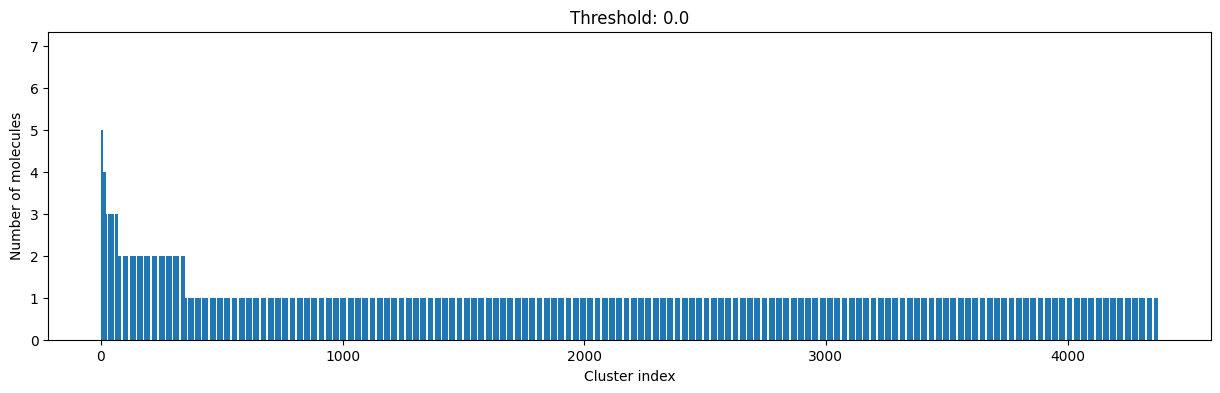

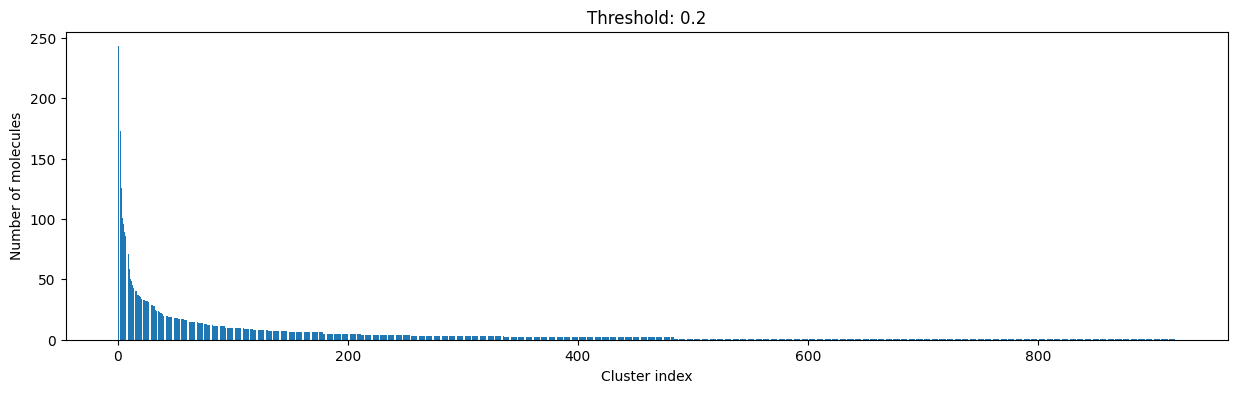

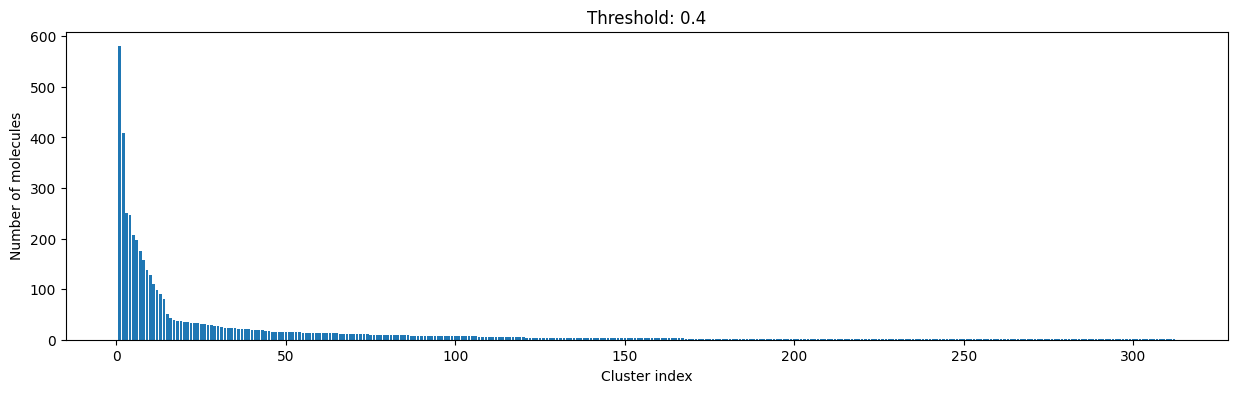

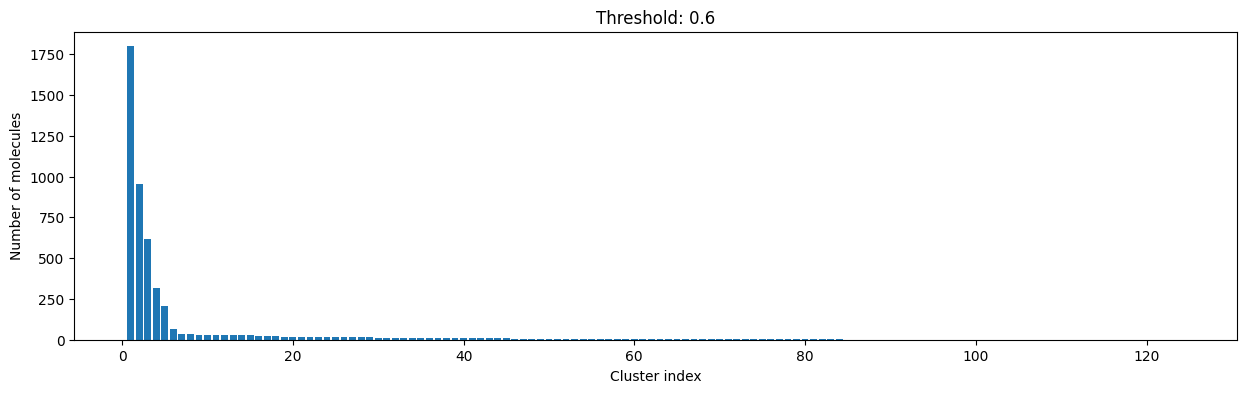

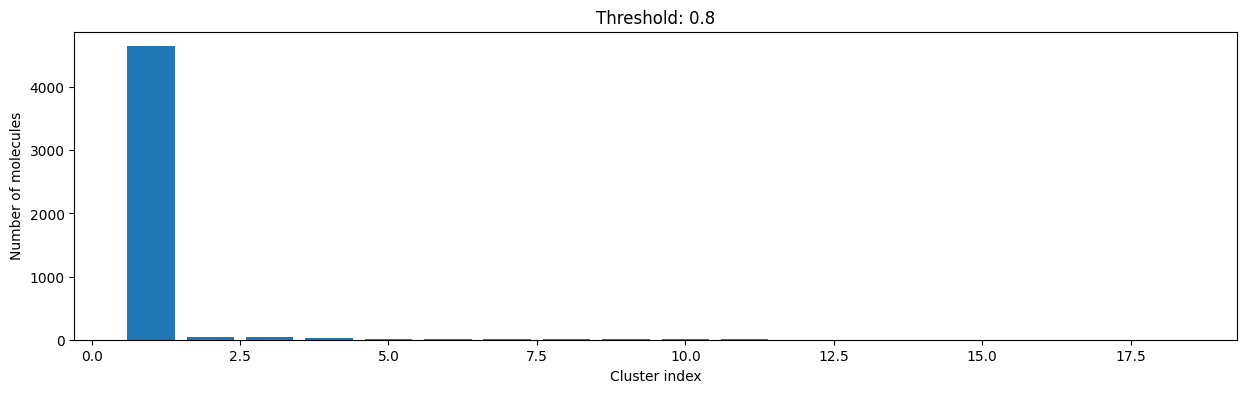

In [10]:
for cutoff in numpy.arange(0.0, 1.0, 0.2):
    clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.set_title(f"Threshold: {cutoff:3.1f}")
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Number of molecules")
    ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)
    display(fig)

When the distance cutoff is higher, this would mean that there are more molecules considered as (enough) similar. This will result in more compounds together in one cluster, and less clusters. On the other side, a too low cutoff will result in a lot small clusters and singletons. In the plots above can be seen that with a cutoff of 0.2, there are no extreme cluster sizes, but also not too many singletons. Therefore the cutoff of 0.2 will be used. 

Number of clusters: 919 from 4823 molecules at distance cut-off 0.20
Number of molecules in largest cluster: 243
Similarity between two random points in same cluster: 0.85
Similarity between two random points in different cluster: 0.34


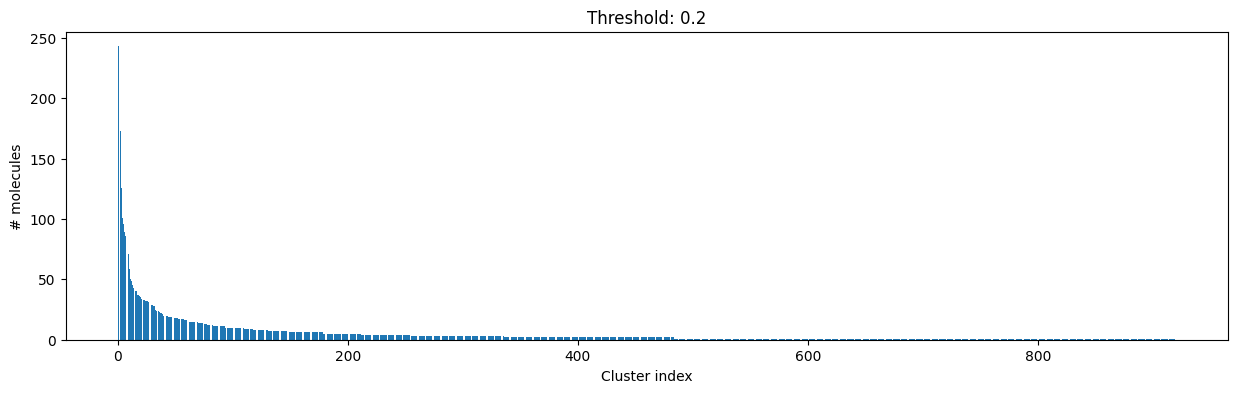

In [11]:
cutoff = 0.2 # Cutoff is set to 0.2
clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)

# Plot the size of the clusters - save plot
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("# molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters])
ax.set_title(f"Threshold: {cutoff:3.1f}")
fig.savefig(
    DATA / f"cluster_dist_cutoff_{cutoff:4.2f}.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

# Print the number of clusters, number of molecules in the largest cluster and similarity of molecules in the same cluster or in different clusters
print(
    f"Number of clusters: {len(clusters)} from {len(compounds)} molecules at distance cut-off {cutoff:.2f}"
)
print("Number of molecules in largest cluster:", len(clusters[0]))
print(
    f"Similarity between two random points in same cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[0][1]]):.2f}"
)
print(
    f"Similarity between two random points in different cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[1][0]]):.2f}"
)

### Save largest cluster

In the next part will the largest cluster be used to determine a maximum common substructure. Therefore, these molecules will be used to use them in the next part. 

In [12]:
# Save molecules from largest cluster
sdf_path = str(DATA / "molecule_set_largest_cluster.sdf")
sdf = Chem.SDWriter(sdf_path)
for index in clusters[0]:
    mol, label = compounds[index]
    # Add label to metadata
    mol.SetProp("_Name", label)
    sdf.write(mol)
sdf.close()